# Evolution de la concentration de CO2 dans l'atmosphère depuis 1958.

Modules Python utilisés dans cette étude

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize # utilisé pour l'optimisation finale
import isoweek
import os
import urllib.request # utile pour créer fichier directement à partir de l'URL

En 1958, Charles David Keeling  a initié une mesure de la concentration de CO2 dans l'atmosphère à l'observatoire de Mauna Loa, Hawaii, États-Unis qui continue jusqu'à aujourd'hui.
Les données sont disponibles sur le [site Web de l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html).

Le format des données est explicité dans le fichier CSV :

"The data file below contains 2 columns indicaing the date and CO2       "
" concentrations in micro-mol CO2 per mole (ppm), reported on the 2008A  "
" SIO manometric mole fraction scale.  These weekly values have been     "
" adjusted to 12:00 hours at middle day of each weekly period as         "
" indicated by the date in the first column.                             "

Les 43 premières lignes sont des commentaires que nous ignorons en précisant skiprows=43.

Vérifions qu'une copie locale des données existe dans le répertoire de travail sinon nous la téléchargeons.

**NB:** La version de la base de données hebdomadaires utilisée dans la création de ce document computationnel a été téléchargé le 12/06/2020.

Nous ajoutons un nom aux colonnes pour les identifier plus facilement par la suite

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
data_file = "concentrationCO2.csv"

os.path.isfile(data_file)
if os.path.isfile(data_file) == 0:
   urllib.request.urlretrieve(data_url, data_file)

raw_data = pd.read_csv(data_file, names = ['date','CO2_concentration'], skiprows=44)
raw_data

date  CO2_concentration
0     1958-03-29             316.19
1     1958-04-05             317.31
2     1958-04-12             317.69
3     1958-04-19             317.58
4     1958-04-26             316.48
5     1958-05-03             316.95
6     1958-05-17             317.56
7     1958-05-24             317.99
8     1958-07-05             315.85
9     1958-07-12             315.85
10    1958-07-19             315.46
11    1958-07-26             315.59
12    1958-08-02             315.64
13    1958-08-09             315.10
14    1958-08-16             315.09
15    1958-08-30             314.14
16    1958-09-06             313.54
17    1958-11-08             313.05
18    1958-11-15             313.26
19    1958-11-22             313.57
20    1958-11-29             314.01
21    1958-12-06             314.56
22    1958-12-13             314.41
23    1958-12-20             314.77
24    1958-12-27             315.21
25    1959-01-03             315.24
26    1959-01-10             315.50
27    1959-01-17             315.69
28    1959-01-24             315.86
29    1959-01-31             315.42
...          ...                ...
3143  2019-11-02             409.86
3144  2019-11-09             410.15
3145  2019-11-16             410.22
3146  2019-11-23             410.48
3147  2019-11-30             410.92
3148  2019-12-07             411.27
3149  2019-12-14             411.67
3150  2019-12-21             412.30
3151  2019-12-28             412.59
3152  2020-01-04             413.19
3153  2020-01-11             413.39
3154  2020-01-25             413.36
3155  2020-02-01             413.99
3156  2020-02-08             414.83
3157  2020-02-15             413.81
3158  2020-02-22             414.17
3159  2020-02-29             413.89
3160  2020-03-07             414.00
3161  2020-03-14             414.30
3162  2020-03-21             414.62
3163  2020-03-28             415.57
3164  2020-04-04             415.61
3165  2020-04-11             416.47
3166  2020-04-18             416.60
3167  2020-04-25             415.86
3168  2020-05-02             417.20
3169  2020-05-09             416.99
3170  2020-05-16             416.54
3171  2020-05-23             417.49
3172  2020-05-30             417.19

[3173 rows x 2 columns]

Y a-t-il des lignes sans données valides dans ce jeux de données ?

In [3]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [date, CO2_concentration]
Index: []

À la date de création de ce document il n'y a pas de données non valides. Cependant on introduisons une procédure pour supprimer les lignes avec de telles données manquantes susceptibles d'être introduite dans la base de données par la suite.

In [4]:
data = raw_data.dropna().copy()
print (data.columns) #verification format du dataframe
data

Index(['date', 'CO2_concentration'], dtype='object')


date  CO2_concentration
0     1958-03-29             316.19
1     1958-04-05             317.31
2     1958-04-12             317.69
3     1958-04-19             317.58
4     1958-04-26             316.48
5     1958-05-03             316.95
6     1958-05-17             317.56
7     1958-05-24             317.99
8     1958-07-05             315.85
9     1958-07-12             315.85
10    1958-07-19             315.46
11    1958-07-26             315.59
12    1958-08-02             315.64
13    1958-08-09             315.10
14    1958-08-16             315.09
15    1958-08-30             314.14
16    1958-09-06             313.54
17    1958-11-08             313.05
18    1958-11-15             313.26
19    1958-11-22             313.57
20    1958-11-29             314.01
21    1958-12-06             314.56
22    1958-12-13             314.41
23    1958-12-20             314.77
24    1958-12-27             315.21
25    1959-01-03             315.24
26    1959-01-10             315.50
27    1959-01-17             315.69
28    1959-01-24             315.86
29    1959-01-31             315.42
...          ...                ...
3143  2019-11-02             409.86
3144  2019-11-09             410.15
3145  2019-11-16             410.22
3146  2019-11-23             410.48
3147  2019-11-30             410.92
3148  2019-12-07             411.27
3149  2019-12-14             411.67
3150  2019-12-21             412.30
3151  2019-12-28             412.59
3152  2020-01-04             413.19
3153  2020-01-11             413.39
3154  2020-01-25             413.36
3155  2020-02-01             413.99
3156  2020-02-08             414.83
3157  2020-02-15             413.81
3158  2020-02-22             414.17
3159  2020-02-29             413.89
3160  2020-03-07             414.00
3161  2020-03-14             414.30
3162  2020-03-21             414.62
3163  2020-03-28             415.57
3164  2020-04-04             415.61
3165  2020-04-11             416.47
3166  2020-04-18             416.60
3167  2020-04-25             415.86
3168  2020-05-02             417.20
3169  2020-05-09             416.99
3170  2020-05-16             416.54
3171  2020-05-23             417.49
3172  2020-05-30             417.19

[3173 rows x 2 columns]

Le format de la date est conventionnelle et compris par la bibliothèque pandas.
En analysant rapidement les données, il est facile de constater qu'il n'y a pas toujours des relevés de la concentration par semaine. Nous pouvons néanmoins utiliser les données telles quelles pour tracer un premier aperçu des données brutes.

## Tracé des données

Nous indexons les données de concentration de C02 avec la date

In [5]:
sorted_data = data.set_index('date').sort_index()
sorted_data

CO2_concentration
date                         
1958-03-29             316.19
1958-04-05             317.31
1958-04-12             317.69
1958-04-19             317.58
1958-04-26             316.48
1958-05-03             316.95
1958-05-17             317.56
1958-05-24             317.99
1958-07-05             315.85
1958-07-12             315.85
1958-07-19             315.46
1958-07-26             315.59
1958-08-02             315.64
1958-08-09             315.10
1958-08-16             315.09
1958-08-30             314.14
1958-09-06             313.54
1958-11-08             313.05
1958-11-15             313.26
1958-11-22             313.57
1958-11-29             314.01
1958-12-06             314.56
1958-12-13             314.41
1958-12-20             314.77
1958-12-27             315.21
1959-01-03             315.24
1959-01-10             315.50
1959-01-17             315.69
1959-01-24             315.86
1959-01-31             315.42
...                       ...
2019-11-02             409.86
2019-11-09             410.15
2019-11-16             410.22
2019-11-23             410.48
2019-11-30             410.92
2019-12-07             411.27
2019-12-14             411.67
2019-12-21             412.30
2019-12-28             412.59
2020-01-04             413.19
2020-01-11             413.39
2020-01-25             413.36
2020-02-01             413.99
2020-02-08             414.83
2020-02-15             413.81
2020-02-22             414.17
2020-02-29             413.89
2020-03-07             414.00
2020-03-14             414.30
2020-03-21             414.62
2020-03-28             415.57
2020-04-04             415.61
2020-04-11             416.47
2020-04-18             416.60
2020-04-25             415.86
2020-05-02             417.20
2020-05-09             416.99
2020-05-16             416.54
2020-05-23             417.49
2020-05-30             417.19

[3173 rows x 1 columns]

### Tracé de toute les données depuis fin mars 1958

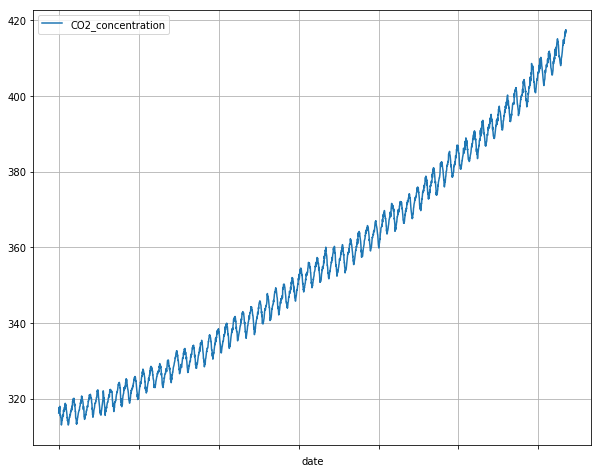

In [6]:
fig1 = data.plot(x='date',y='CO2_concentration',figsize=(10,8))
data_size = len(data['date'])
plt.grid()

Il existe clairement deux tendances. Une tendance à cours terme et une à long terme.

Étudions d'abors la tendance oscillatoire à court terme en traçant ces données sur les dernières années. 

### Tracé des données sur les 110 données les plus récentes (>2*52 semaines = 2 ans si pas de trou)

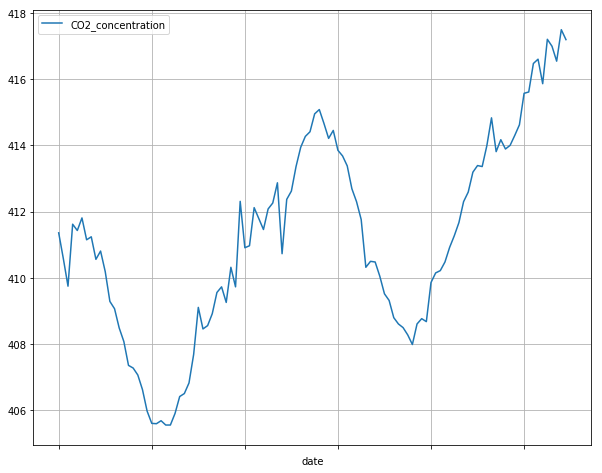

In [7]:
fig2 = data[-110:].plot(x='date',y='CO2_concentration', figsize=(10,8))
plt.grid()

## Ré-échantillonnage régulier des données

Pour avoir un échantillonnage régulier des données nous allons moyenner sur un mois à chaque fois.
Nous allons d'abord extraire les années et mois sous forme de 2 colonnes supplémentaires.

In [8]:
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data

date  CO2_concentration  year  month
0     1958-03-29             316.19  1958      3
1     1958-04-05             317.31  1958      4
2     1958-04-12             317.69  1958      4
3     1958-04-19             317.58  1958      4
4     1958-04-26             316.48  1958      4
5     1958-05-03             316.95  1958      5
6     1958-05-17             317.56  1958      5
7     1958-05-24             317.99  1958      5
8     1958-07-05             315.85  1958      7
9     1958-07-12             315.85  1958      7
10    1958-07-19             315.46  1958      7
11    1958-07-26             315.59  1958      7
12    1958-08-02             315.64  1958      8
13    1958-08-09             315.10  1958      8
14    1958-08-16             315.09  1958      8
15    1958-08-30             314.14  1958      8
16    1958-09-06             313.54  1958      9
17    1958-11-08             313.05  1958     11
18    1958-11-15             313.26  1958     11
19    1958-11-22             313.57  1958     11
20    1958-11-29             314.01  1958     11
21    1958-12-06             314.56  1958     12
22    1958-12-13             314.41  1958     12
23    1958-12-20             314.77  1958     12
24    1958-12-27             315.21  1958     12
25    1959-01-03             315.24  1959      1
26    1959-01-10             315.50  1959      1
27    1959-01-17             315.69  1959      1
28    1959-01-24             315.86  1959      1
29    1959-01-31             315.42  1959      1
...          ...                ...   ...    ...
3143  2019-11-02             409.86  2019     11
3144  2019-11-09             410.15  2019     11
3145  2019-11-16             410.22  2019     11
3146  2019-11-23             410.48  2019     11
3147  2019-11-30             410.92  2019     11
3148  2019-12-07             411.27  2019     12
3149  2019-12-14             411.67  2019     12
3150  2019-12-21             412.30  2019     12
3151  2019-12-28             412.59  2019     12
3152  2020-01-04             413.19  2020      1
3153  2020-01-11             413.39  2020      1
3154  2020-01-25             413.36  2020      1
3155  2020-02-01             413.99  2020      2
3156  2020-02-08             414.83  2020      2
3157  2020-02-15             413.81  2020      2
3158  2020-02-22             414.17  2020      2
3159  2020-02-29             413.89  2020      2
3160  2020-03-07             414.00  2020      3
3161  2020-03-14             414.30  2020      3
3162  2020-03-21             414.62  2020      3
3163  2020-03-28             415.57  2020      3
3164  2020-04-04             415.61  2020      4
3165  2020-04-11             416.47  2020      4
3166  2020-04-18             416.60  2020      4
3167  2020-04-25             415.86  2020      4
3168  2020-05-02             417.20  2020      5
3169  2020-05-09             416.99  2020      5
3170  2020-05-16             416.54  2020      5
3171  2020-05-23             417.49  2020      5
3172  2020-05-30             417.19  2020      5

[3173 rows x 4 columns]

Nous pouvons maintenant sélectionner les éléments de la base de donnée qui se référent à une année. Puis au sein de ceux-ci nous sélectionnons les mesures d'un même mois et nous en prenons la moyenne. Nous recréons ensuite un dataframe avec ces nouvelles données.
*NB : Cela revient à un léger filtrage pase-bas des fluctuations observées dans un mois.*

In [9]:
Monthly_data_list=[]
years=data['year'].unique()
for a in years:
    months_per_year = data['month'][(data.year == a)].unique()
    for b in months_per_year:
        date = str(a) + "-" + str(b)
        Monthly_data_per_year = [date, round(data['CO2_concentration'][(data.year == a) & (data.month == b)].mean(),2),a,b]
        Monthly_data_list.append(Monthly_data_per_year)

Monthly_data=pd.DataFrame(Monthly_data_list)        
Monthly_data.columns = ['date','CO2_concentration_moyenne_mensuelle','year','month']
Monthly_data
database_size = len(Monthly_data['date'])

### Tracé des  données moyennées par mois depuis fin mars 1958

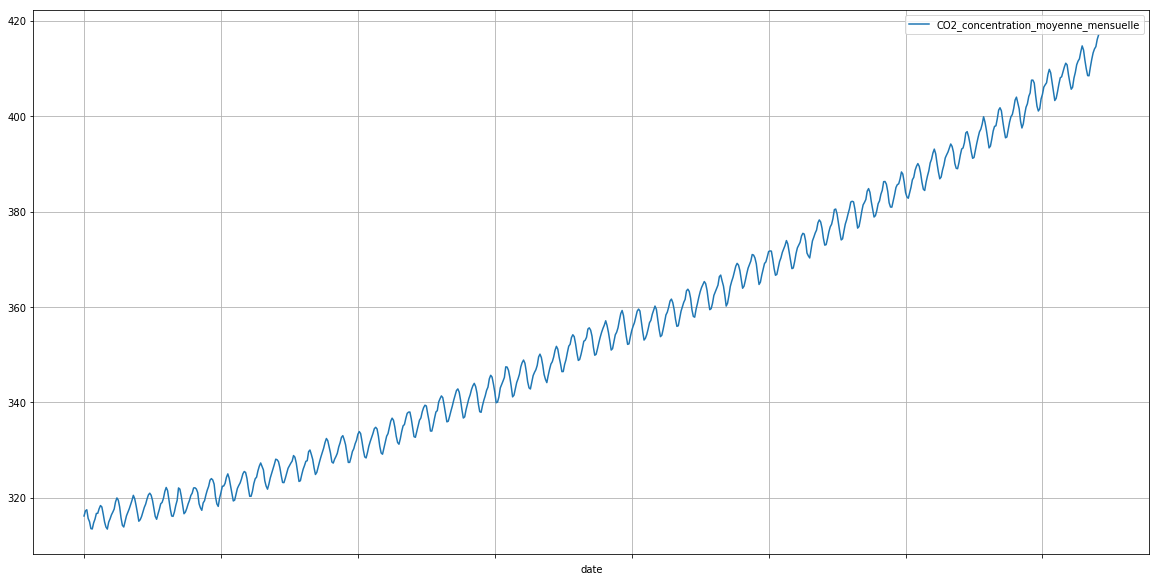

In [10]:
fig3 = Monthly_data.plot(x = 'date',y = 'CO2_concentration_moyenne_mensuelle',figsize=(20,10))
plt.grid()
# Les dates ne veulent pas s'afficher en abscisse ? À résoudre ultérieurement...

### Tracé des  données sur les deux année 2018 et 2019

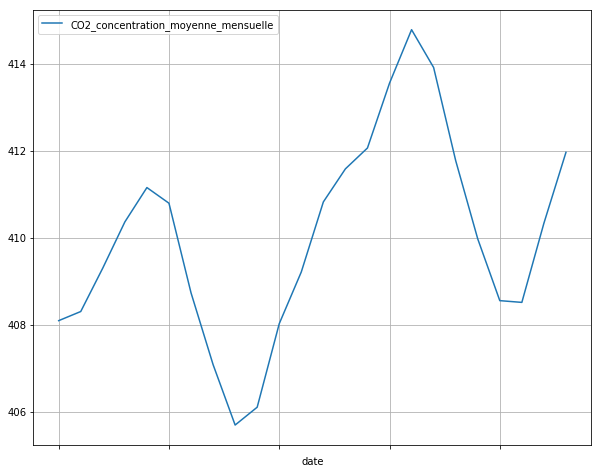

In [38]:
fig4 = Monthly_data[(Monthly_data.year == 2018) | (Monthly_data.year == 2019)].plot(x = 'date',y = 'CO2_concentration_moyenne_mensuelle',figsize=(10,8))
plt.grid()

# Les dates ne veulent pas s'afficher en abscisse ? À résoudre ultérieurement...

Date (année-mois) du minimum de 2009 à 2019

In [12]:
annees = [2009+i for i in range(10)]
min_annees = []
date_min_annees = []
j = 0
for i in annees:
    min_annees.append(Monthly_data['CO2_concentration_moyenne_mensuelle'][(Monthly_data.year == i)].min())
    date_min_annees.append(Monthly_data['date'][(Monthly_data.year == i) & (Monthly_data['CO2_concentration_moyenne_mensuelle'] == min_annees[j])])
    print('min de l\'année',i,':', min_annees[j],'à la date:',date_min_annees[j])
    j = j+1

min de l'année 2009 : 384.45 à la date: 614    2009-10
Name: date, dtype: object
min de l'année 2010 : 386.9 à la date: 625    2010-9
Name: date, dtype: object
min de l'année 2011 : 389.02 à la date: 638    2011-10
Name: date, dtype: object
min de l'année 2012 : 391.2 à la date: 649    2012-9
Name: date, dtype: object
min de l'année 2013 : 393.38 à la date: 661    2013-9
Name: date, dtype: object
min de l'année 2014 : 395.5 à la date: 673    2014-9
Name: date, dtype: object
min de l'année 2015 : 397.56 à la date: 685    2015-9
Name: date, dtype: object
min de l'année 2016 : 401.12 à la date: 697    2016-9
Name: date, dtype: object
min de l'année 2017 : 403.32 à la date: 709    2017-9
Name: date, dtype: object
min de l'année 2018 : 405.69 à la date: 721    2018-9
Name: date, dtype: object


De la position des minima, on peut en deduire que la périodicité de la variation rapide est de l'ordre de l'année (nous préciserons cela plus loin) et que le minimum de C02 à Mauna Loa, Hawaii, États-Unis (lieu des mesures) est en septembre ou octobre.

## Étude spectrale des données pour séparer et caractériser les deux phénomènes rapide puis lent

### Calcul du spectre sur toutes les données 


**Attention les fréquences négatives de la FFT sont situées dans le seconde moitiée du spectre**

In [13]:
data_pour_fft = np.array(Monthly_data['CO2_concentration_moyenne_mensuelle'])
data_pour_fft
fft_data = np.fft.fft(data_pour_fft)
freq_pos = np.fft.fftfreq(len(fft_data))

Creation d'un tableau avec les fréquences negatives pour affichage courbe et classement du tableau des données fft  de la même façon pour obtenir spectre classique symétrique par rapport à la fréquence nulle (concentration constante de C02) 

In [14]:
freq = [] 
freq.extend(freq_pos[int(len(freq_pos)/2):len(freq_pos)-1]-freq_pos[len(freq_pos)-1])
freq.extend(freq_pos[0:int(len(freq_pos)/2)])

fft_data_plot = [] 
fft_data_plot.extend(fft_data[int(len(freq_pos)/2):len(freq_pos)-1])
fft_data_plot.extend(fft_data[0:int(len(freq_pos)/2)])

### Tracé du spectre complet

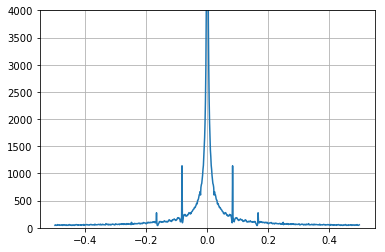

In [39]:
mod_fft_data_plot=[abs(fft_data_plot[i]) for i in range(len(fft_data_plot))]
fig5 = plt.plot(freq,mod_fft_data_plot)
axes = plt.gca()
#axes.set_xlim() # non utilise 
axes.set_ylim(0, 4000)
plt.grid()

### Tracé des fréquences positives uniquement

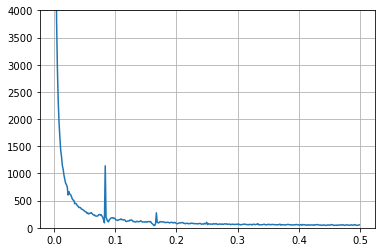

In [40]:
fig6 = plt.plot(freq[int(len(freq_pos)/2):len(freq_pos)-1],mod_fft_data_plot[int(len(freq_pos)/2):len(freq_pos)-1])
axes = plt.gca()
#axes.set_xlim(0, 0.1)
axes.set_ylim(0, 4000)
plt.grid()

Nous avons mis en évidence le comportement oscillant de la concentration de C02 visible au travers du contenu spectral très marqué autour de 0.1. On note aussi la présence d'un peu d'harmonique 2. Le phénomène n'est pas une oscillation pure mono-fréquentielle. Nous allons filtrer ce contenu.

Cherchons l'index de la fréquence du maximum proche de freq=0.01 dans le tableau de la fft de départ
Pour cela nous traçons cette fois le spectre en fonction de l'indice du tableau de valeurs. 

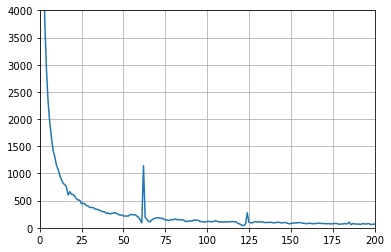

In [41]:
fig7 = plt.plot(abs(fft_data[0:int(len(fft_data)/2)-1]))
axes = plt.gca()
axes.set_xlim(0, 200)
axes.set_ylim(0, 4000)
plt.grid()

## Conclusion sur le phénomène rapide

À partir de cette courbe nous pouvons déterminer précisément la fréquence des oscillations rapide (calcul suivant).
Le résultat met en évidence une fréquence à $0.084 mois^{-1}= \frac{1}{12} mois^{-1}$, soit une période d'une année.

Nous retrouvons le résultat entrevue par la recherche des minima au départ. Nous pouvons préciser que le phénomène n'est pas purement sinusoïdal car nous avons clairement une composante à l'harmonique 2 soit $1.67 mois^{-1}= \frac{2}{12} mois^{-1}$.

***Hyp :*** Le phénomène n'est probablement pas directement lié à la différence d'activité humaine à Hawaï selon la période été/hiver, mais plus probablement à un stockage du C02 cyclique dans l'océan qui entoure la station de mesure sur l'île.

In [20]:
vmax= fft_data[50:75].max()
print('vmax = ',vmax)
imax = np.where(fft_data == vmax)[0][0]
print('index = ',imax)
freqmax = freq_pos[imax]
print('frequence du maximum local =', freqmax)

vmax =  (178.51619865797664+1126.1445008434132j)
index =  62
frequence du maximum local = 0.08355795148247978


## Caractérisation du phénomène lent
Nous pouvons maintenant filtrer grossièrement les données spectrales en *supprimant* les pics parasites, tant sur les fréquences positives que négatives, pour essayer de préciser la nature de la variation lente observée sous la variation rapide.

**NB :** Il est bien sûr possible de réaliser un filtrage passe-bas plus conventionnel mais l'approche donnée ici suffit pour modéliser le phénomène lent afin d'obtenir une extrapolation de l'évolution à moyen terme (2025).

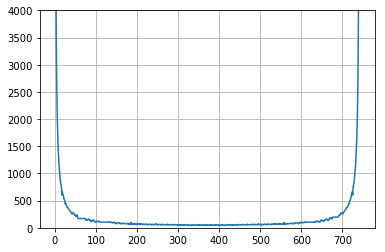

In [21]:
fft_data_filtree = np.copy(fft_data)
for i in range(55,75):
    fft_data_filtree[i]=(fft_data_filtree[55]+fft_data_filtree[75])/2
for i in range(110,130):
    fft_data_filtree[i] = (fft_data_filtree[110]+fft_data_filtree[130])/2
for i in range(675,690):
    fft_data_filtree[i]=(fft_data_filtree[675]+fft_data_filtree[690])/2
for i in range(610,630):
    fft_data_filtree[i]=(fft_data_filtree[610]+fft_data_filtree[630])/2
    
    
mod_fft_data_filtree = np.abs(fft_data_filtree)
fig8 = plt.plot(mod_fft_data_filtree)
axes = plt.gca()
#axes.set_xlim(0, 200)
axes.set_ylim(0, 4000)
plt.grid()

In [23]:
filtered_data = np.fft.ifft(fft_data_filtree)
Monthly_data['filtered_data'] = np.around(np.abs(filtered_data[0:len(filtered_data)]),decimals=2)
Monthly_data

date  CO2_concentration_moyenne_mensuelle  year  month  filtered_data
0     1958-3                               316.19  1958      3         312.80
1     1958-4                               317.26  1958      4         315.57
2     1958-5                               317.50  1958      5         318.40
3     1958-7                               315.69  1958      7         318.69
4     1958-8                               314.99  1958      8         318.58
5     1958-9                               313.54  1958      9         316.32
6    1958-11                               313.47  1958     11         314.99
7    1958-12                               314.74  1958     12         315.39
8     1959-1                               315.54  1959      1         315.71
9     1959-2                               316.72  1959      2         316.19
10    1959-3                               316.75  1959      3         314.88
11    1959-4                               317.70  1959      4         314.34
12    1959-5                               318.38  1959      5         314.49
13    1959-6                               318.08  1959      6         315.38
14    1959-7                               316.58  1959      7         316.40
15    1959-8                               314.92  1959      8         317.24
16    1959-9                               313.87  1959      9         317.39
17   1959-10                               313.44  1959     10         316.61
18   1959-11                               314.90  1959     11         316.93
19   1959-12                               315.58  1959     12         316.65
20    1960-1                               316.42  1960      1         316.95
21    1960-2                               317.00  1960      2         316.89
22    1960-3                               317.64  1960      3         316.26
23    1960-4                               319.15  1960      4         316.15
24    1960-5                               319.97  1960      5         316.03
25    1960-6                               319.51  1960      6         316.25
26    1960-7                               318.09  1960      7         317.05
27    1960-8                               315.80  1960      8         317.38
28    1960-9                               314.23  1960      9         317.46
29   1960-10                               313.88  1960     10         317.22
..       ...                                  ...   ...    ...            ...
712  2017-12                               406.76  2017     12         407.10
713   2018-1                               408.09  2018      1         407.51
714   2018-2                               408.30  2018      2         407.17
715   2018-3                               409.30  2018      3         407.43
716   2018-4                               410.36  2018      4         407.56
717   2018-5                               411.15  2018      5         407.95
718   2018-6                               410.79  2018      6         408.48
719   2018-7                               408.73  2018      7         408.60
720   2018-8                               407.08  2018      8         409.37
721   2018-9                               405.69  2018      9         409.36
722  2018-10                               406.10  2018     10         409.52
723  2018-11                               408.02  2018     11         410.09
724  2018-12                               409.21  2018     12         409.84
725   2019-1                               410.82  2019      1         410.53
726   2019-2                               411.58  2019      2         410.70
727   2019-3                               412.06  2019      3         410.37
728   2019-4                               413.55  2019      4         410.80
729   2019-5                               414.78  2019      5         411.39
730   2019-6                               413.91  2019      6         411.16
731   2019-7                  

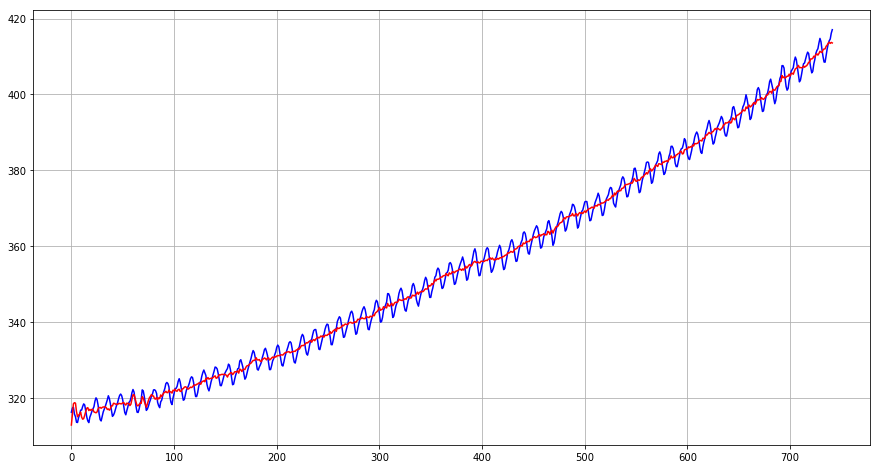

In [24]:
trace=['CO2_concentration_moyenne_mensuelle','filtered_data']
couleur = ['blue','red']
j=0
fig9 = plt.figure(figsize=(15,8))
plt.grid()
for i in trace:
    plt.plot(Monthly_data[i],color=couleur[j]) 
    j=j+1
    #L'indice correspond au nombre de mois depuis la date de la première mesure en 1958-8

L'allure de la courbe filtrée laisse à penser que la variation est de type exponentielle mais avec un coefficient petit. Cette hypothèse est bien sûr difficile à affirmer compte tenu de la faible courbure sur les 60 et quelques années de données.
Nous allons tenter d'obtenir les carcatéristique de l'exponentielle qui s'ajustera au mieux aux données de la concentration mensuelle de C02 filtrée.
La fonction considérée est: $f_{CO2}=A.e^{at}+B$ .

In [36]:
# Pour le temps on choisit l'indice des data filtrées.
# L'écart entre deux données est le mois, après moyennage sur chaque mois de chaque année

taille = len(Monthly_data['filtered_data']) 
t=range(taille)
C_CO2 = Monthly_data['filtered_data']

#Définition des fonctions utilisées pour l'optimisation
def f_CO2_exp(t,A,B,a): # Concentration en CO2 calculée par un modèle exponentiel
    D=[]
    n=len(t)
    for i in range(n):
        fco2=A*np.exp(a*t[i])+B
        D.append(fco2)
    return D

def residuals_exp(parametres): # Calcul de la fonction d'erreur quadratique entre les données et la fonction modèle
    A,B,a = parametres
    return np.sum((np.array(C_CO2) - np.array(f_CO2_exp(t,A,B,a)))**2)

## Initialisation valeurs pour optimisation
parametres=(0.1,300,0.0001)
#bndsMinimize = ((0, 1), (300, 350),(0, 0.1))
bndsCurveFit = ([0, 250, 0], [ 100, 350, 0.01])
#res = optimize.minimize(residuals, parametres, method='SLSQP', bounds=bndsMinimize, options={'ftol': 1e-9, 'disp': True})
popt, pcov = optimize.curve_fit(f_CO2_exp, t, C_CO2, p0=parametres, bounds=bndsCurveFit, maxfev = 10000)
Aopt,Bopt,aopt=popt
print('A = ',int(Aopt),' B = ',int(Bopt),' a = ',round(aopt,7))

A =  56  B =  257  a =  0.0013751


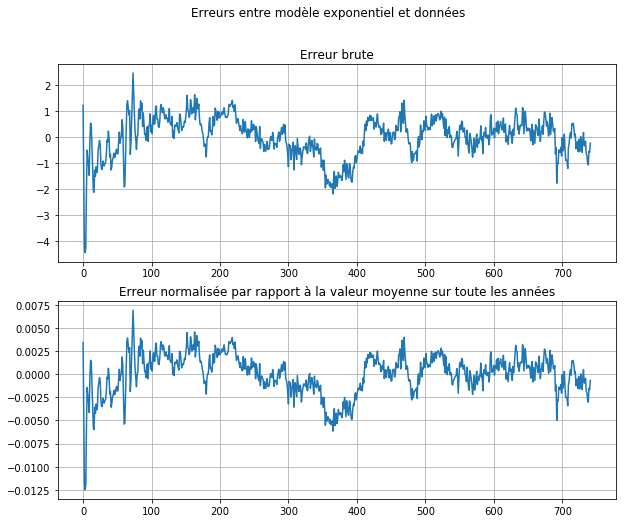

In [33]:
fig10 = plt.figure(1,figsize=(10, 8))
plt.suptitle("Erreurs entre modèle exponentiel et données")

plt.subplot(211)
plt.plot(f_CO2_exp(t,Aopt,Bopt,aopt)-Monthly_data['filtered_data'],label="Erreur brute")
plt.title("Erreur brute")
plt.grid()

plt.subplot(212)
moyenne_CO2 = Monthly_data['filtered_data'].mean()
plt.plot((f_CO2_exp(t,Aopt,Bopt,aopt)-Monthly_data['filtered_data'])/moyenne_CO2)
plt.title("Erreur normalisée par rapport à la valeur moyenne sur toute les années")
plt.grid()

Les courbes sur les erreurs montre que le modèle exponentielle est assez juste.

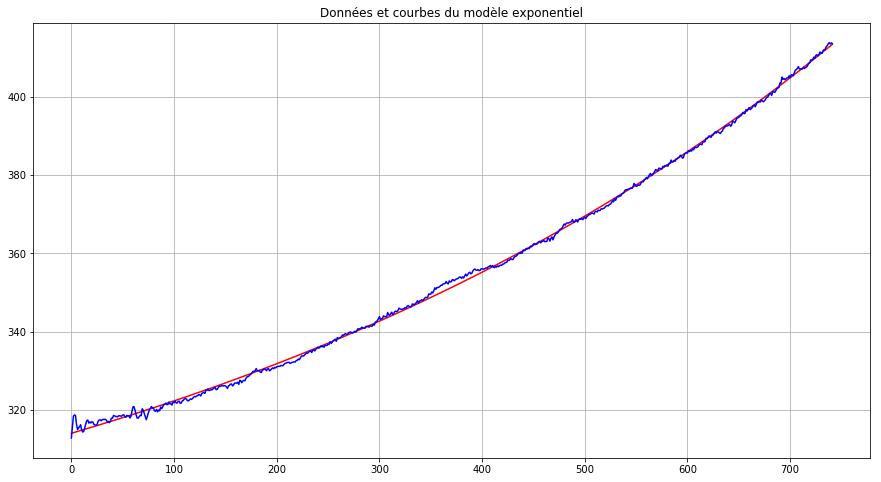

In [37]:
plt.figure(figsize=(15,8))
plt.title('Données et courbe du modèle exponentiel')
plt.plot(f_CO2_exp(t,Aopt,Bopt,aopt),'red')
plt.plot(Monthly_data['filtered_data'], 'blue')
plt.grid()

Notre modèle semble relativement bien fonctionner avec la modélisation exponentielle. Il est à noter que la concentration initiale  (B) du modèle est fixée par la relative "jeunesse" des données.
**Rmq :** On pourraît encore affiner la précision du modèle en supprimant les données oscillantes initiales ou en en moyennant leur fluctuation.
Nous allons maintenant extrapoler la contration de CO2 à **janvier 2025**. Ainsi de future données permettront de valider ou non le modèle fait ce jour (juin 2020).
Pour cela nous allons calculer le nombre de mois entre la dernière mesures et **janvier 2025**. Ce nombre de mois sera à ajouter à l'indice finale des données pour obtenir l'extrapolation.

In [59]:
# Dernière année des données
last_year = Monthly_data['year'][taille-1]
# Dernier mois des données
last_month_last_year = Monthly_data['month'][taille-1]
ecart_next_year = 12 - last_month_last_year #en mois
ecart_next_year_2025 = 2025 - (last_year + 1)
ecart_month_to_2025 = ecart_next_year + 12 *ecart_next_year_2025
#print(last_year,last_month_last_year,ecart_next_year,ecart_next_year_2025,ecart_month_to_2025)
indice_temps_en_mois = (taille-1) + ecart_month_to_2025 # (taille-1) est le dernier indice de la matrice Monthly_data 
#print(indice_temps_en_mois)
C02_extrapolee_2015 = round(Aopt*np.exp(aopt*indice_temps_en_mois)+Bopt,2) # calcul direct de la valeur
print('Contration extrapolée en micro-mol CO2 par mole (ppm) = ',C02_extrapolee_2015)
var_rel = round((C02_extrapolee_2015 - Monthly_data['CO2_concentration_moyenne_mensuelle'][taille-1])/Monthly_data['CO2_concentration_moyenne_mensuelle'][taille-1]*100,2)
print('Soit une variation relative par rapport à la dernière mesure de ',var_rel,'%')

Contration extrapolée en micro-mol CO2 par mole (ppm) =  425.55
Soit une variation relative par rapport à la dernière mesure de  2.03 %


## Conlusion sur le phénomène lent
La variation lente est apparemment de type exponentielle.

Une extrapolation à **Janvier 2015** donne une concentration de CO2 à $\textbf{425.55 ppm}$.

Ceci représente une augmentation de  $\textbf{2.03 %}$ en un peu moins de **5 ans**.

Nous donnons au final la courbe de la variation lente extrapolée jusqu'à janvier 2015, combinée avec les données mensuelles complètes.

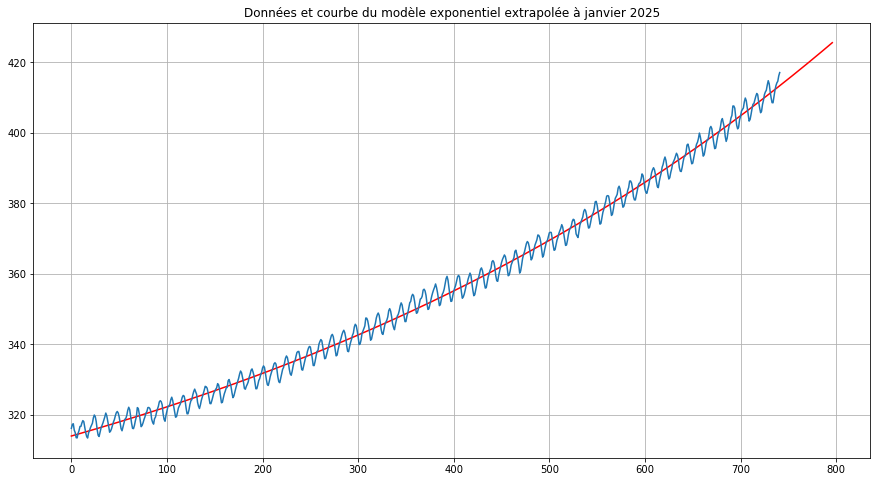

In [61]:
t_extrapol=[i for i in range(taille+ecart_month_to_2025)]
plt.figure(figsize=(15,8))
plt.title('Données et courbe du modèle exponentiel extrapolée à janvier 2025')
plt.plot(f_CO2_exp(t_extrapol,Aopt,Bopt,aopt),'red')
plt.plot(Monthly_data['CO2_concentration_moyenne_mensuelle'])
plt.grid()
